In [1]:
%cd ..

/home/ubuntu/OptiServe


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import datetime


from src.analytics.aws_function_logs import AWSFunctionLogs
from src.profiler.cost_calculator import CostCalculator
from src.modeling.function_performance_modeling import FunctionPerformanceModeling
from src.profiler.explorer import Explorer
from src.optimizer.parametric_function import ParamFunction

In [3]:
payload = '{"bucket_name": "test-images-mohammad", "num_images": 24, "batch_size": 4, "model_name": "yolov10n"}'
region_name = 'us-east-1'

memeory_bounds = [(1024, 10000)]
available_models = [
    #'resnet-18',
    # 'resnet-34',
    #'resnet-50',
    #'resnet-101',
    'yolov10n',
]
memory_space_step = 256

function_name = f"yolo"

duration_per_memory = {}

for model in available_models:
    duration_per_memory[model] = ParamFunction.load('modeled_functions/' + function_name + '_' + model + '.mdl')

In [27]:
# p_model = FunctionPerformanceModeling(
#     function_name=function_name,
#     payload=payload,
#     memory_bounds=memeory_bounds,
#     profiling_iterations=3
# )
# o_memory = p_model.get_optimal_memory()
# print(f"Optimal memory for {function_name} is {o_memory}")

duration_per_memory = {}
for model in available_models:
    duration_per_memory[model] = ParamFunction.load(f'modeled_functions/{function_name}_{model}.mdl')
# del p_model

In [ ]:
explorer = Explorer(
    function_name=function_name,
    payload=payload,
    boto_session=boto3.Session(region_name=region_name),
    memory_space_step=memory_space_step,
    max_invocations=2,
    available_models = available_models,
    memory_bounds=memeory_bounds
)

explorer.explore_all_memories(num_of_invocations=10)

Processing:   8%|▊          [Elapsed: 01:27 | Remaining: 15:36]

In [4]:
aws_logs = AWSFunctionLogs(
    boto_session=boto3.Session(region_name=region_name),
    function_name=function_name,
    docker_deploy=True
)

for model in available_models:
    df = aws_logs.get_logs_df(start_time=int((datetime.datetime.utcnow() - datetime.timedelta(days=3)).timestamp()),
    end_time=int(datetime.datetime.utcnow().timestamp()), model_name=model)

    df.to_csv(f'{function_name}_{model}_logs.csv')

In [5]:
cost_calculator = CostCalculator(
    function_name=function_name,
)

# cost_calculator.calculate_cost(memory_mb=2048, duration=1000, num_of_invocations=1000)

In [6]:
dfs = {}
for model in available_models:
    dfs[model] = pd.read_csv(f'{function_name}_{model}_logs.csv')

In [7]:
logs = {}
for model in available_models:
    logs[model] = dfs[model][dfs[model]['Init Duration'].isna()]

    # logs[model] = logs[model].groupby('Memory Size').agg({
    #     'Duration': 'mean',
    # }).reset_index()

    if 'Duration' in logs[model].columns and 'Memory Size' in logs[model].columns:
        # Calculate the cost using .loc to avoid SettingWithCopyWarning
        logs[model].loc[:, 'Cost'] = logs[model].apply(
            lambda row: cost_calculator.calculate_cost(
                memory_mb=row['Memory Size'],
                duration_ms=row['Duration']
            ) * 1_000_000,
            axis=1
        )

/tmp/ipykernel_59998/4263560648.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs[model].loc[:, 'Cost'] = logs[model].apply(


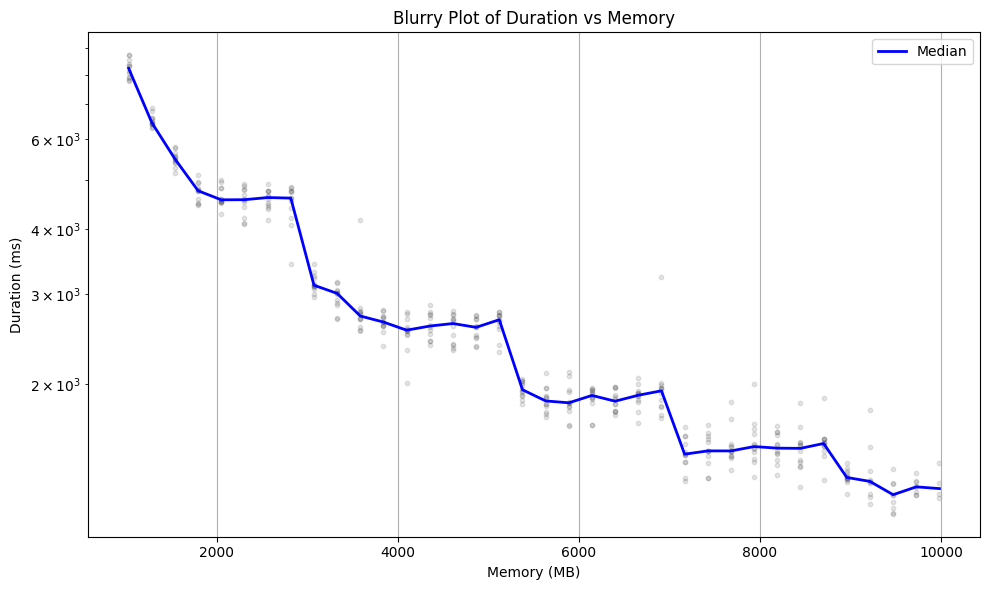

In [9]:
plt.figure(figsize=(10, 6))

# Blurry scatter plot
plt.scatter(logs['yolov10n']["Memory Size"], logs['yolov10n']["Duration"], alpha=0.1, s=10, color="black")

# Overlay median line
median_durations = logs['yolov10n'].groupby("Memory Size")["Duration"].median()
plt.plot(median_durations.index, median_durations.values, color="blue", linewidth=2, label="Median")

# Axis labels, scaling, and formatting
plt.xlabel("Memory (MB)")
plt.ylabel("Duration (ms)")
plt.yscale("log")
plt.title("Blurry Plot of Duration vs Memory")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
modeled_durations = {}
modeled_costs = {}

for i, model in enumerate(available_models):
    memory_bound = memeory_bounds[i]
    memory_space = np.arange(memory_bound[0], memory_bound[1] + 1)

    logs[model] = logs[model][logs[model]['Memory Size'].isin(memory_space)]

    modeled_duration = []
    modeled_cost = []

    for memory in memory_space:
        t = duration_per_memory[model](memory)
        modeled_duration.append(t)
        modeled_cost.append(cost_calculator.calculate_cost(memory_mb=memory, duration_ms=t) * 1_000_000)

    modeled_duration = np.array(modeled_duration)
    modeled_cost = np.array(modeled_cost)
    modeled_durations[model] = modeled_duration
    modeled_costs[model] = modeled_cost

In [25]:
logs

{'resnet-50':     Memory Size   Duration        Cost
 0        1024.0  8981.4675  149.900299
 1        1280.0  6705.5915  139.908613
 2        1536.0  5773.1225  144.550289
 3        1792.0  4859.0670  141.950284
 4        2048.0  4060.1020  135.566937
 5        2304.0  3693.3500  138.725277
 6        2560.0  3219.4505  134.366935
 7        2816.0  2866.0175  131.604429
 8        3072.0  2883.6185  144.400288
 9        3328.0  2686.1760  145.746124
 10       3584.0  2509.8300  146.616960
 11       3840.0  2868.8080  179.512859
 12       4096.0  2795.2470  186.600373
 13       4352.0  2022.2580  143.496120
 14       4608.0  1948.6080  146.375292
 15       4864.0  1853.5545  146.975294
 16       5120.0  1733.6395  144.700289
 17       5376.0  1680.7535  147.287794
 18       5632.0  1527.4495  140.266947
 19       5888.0  1521.2035  146.058625
 20       6144.0  1514.1115  151.700303
 21       6400.0  1457.0515  152.075304
 22       6656.0  1370.2725  148.725297
 23       6912.0  1365.9490

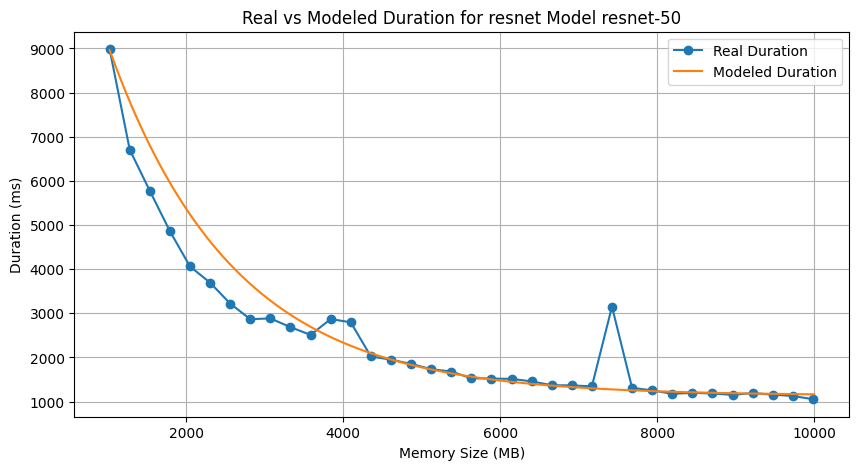

In [26]:
for i, model in enumerate(available_models):
    modeled_duration = modeled_durations[model]
    memory_bound = memeory_bounds[i]
    memory_space = np.arange(memory_bound[0], memory_bound[1] + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(logs[model]['Memory Size'], logs[model]['Duration'], label='Real Duration', marker='o')
    plt.plot(memory_space, modeled_duration, label='Modeled Duration')
    plt.xlabel('Memory Size (MB)')
    plt.ylabel('Duration (ms)')
    plt.title(f'Real vs Modeled Duration for {function_name} Model {model}')
    plt.legend()
    plt.grid()

    plt.show()